In [1]:
import cedalion
import cedalion.nirs
import cedalion.xrutils as xrutils
import numpy as np
import xarray as xr
import pint
import matplotlib.pyplot as p
import scipy.signal as signal
import os.path

xr.set_options(display_expand_data=False)


In [2]:
DATADIR = "/Users/lauracarlton/Library/CloudStorage/GoogleDrive-lcarlton@bu.edu/My Drive/fNIRS/Data/OLD_FT/BIDS-NIRS-Tapping/"
elements = cedalion.io.read_snirf(DATADIR + "sub-01/nirs/sub-01_task-tapping_nirs.snirf")

amp = elements[0].data[0]


In [3]:
def plot_channel(array, channel, ylabel, xlabel="time", tmin=0, tmax=1000):
    f, ax = p.subplots(1,1, figsize=(12,4))
    ax.plot(array.time, array.sel(channel=channel, wavelength=760), "r-")
    ax.plot(array.time, array.sel(channel=channel, wavelength=850), "b-")
    p.xlim(tmin, tmax)
    p.xlabel(xlabel)
    p.ylabel(ylabel)


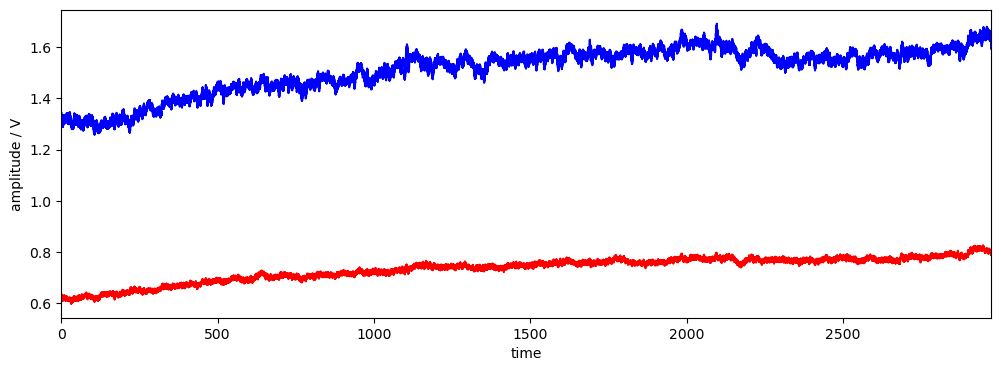

In [4]:
plot_channel(amp, "S5D7", "amplitude / V", tmin = 0, tmax = max(amp.time))


In [5]:
dod =  -np.log( amp / amp.mean("time"))

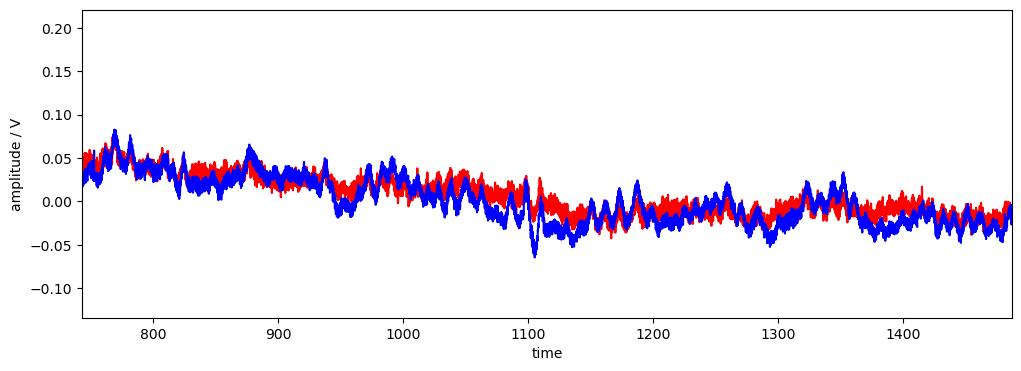

In [6]:
plot_channel(dod, "S5D7", "amplitude / V", tmin = max(dod.time)//4, tmax = max(dod.time)//2)


In [9]:
# need to first correct for baseline shifts
iqr = 1.5
iqr2 = 2
tMotion = 1
fs =  dod.cd.sampling_rate
Win_size = int(np.round(fs*tMotion))
SNR_thre = np.zeros(dod.shape[0])


In [10]:
from tqdm import tqdm 
s1 = dod.sel(channel='S1D1', wavelength=850, time=dod.time[np.arange(10000)])

#for s1 in dod[:1000,1]:
    
# filter data between 0, 2 
s1 = s1.cd.freq_filter(0.001, 2, butter_order=4)

# filter data between 0 0.5
s2 = s1.cd.freq_filter(0.001, 0.5, butter_order=4)

# detect outliers in std variations of the signal 
windows = s2.rolling(time=Win_size).construct("window", stride=1)
sigSTD = windows.std("window")

quants_std = sigSTD.quantile([0.25,0.5,0.75])
IQR_std = quants_std[2] - quants_std[0]
high_std = quants_std[2] + IQR_std*iqr2
low_std = quants_std[0] - IQR_std*iqr2


# detect outliers in gradient of the signal
grad = s1.copy()
grad.values = signal.convolve(s1.values, [-1,0,1], mode='same')

quants_grad = grad.quantile([0.25,0.5,0.75])
IQR1 = quants_grad[2] - quants_grad[0]
high = quants_grad[2] + IQR1*iqr
low = quants_grad[0] - IQR1*iqr


# union of all outliers
z_std = 0
M_std = []
for ii in tqdm(range(int(len(s1)-Win_size))):

    if sigSTD[ii]>high_std or sigSTD[ii]<low_std:
        z_std = z_std + 1
        M_std.append(ii)

if len(M_std) != 0:
    M_std = np.round(Win_size/2) + M_std
    
    
z=0
M_sobel = []
for ii in tqdm(range(int(len(s1)))):

    if grad[ii]>high or grad[ii]<low:
        z = z + 1
        M_sobel.append(ii)
    
        
if len(M_std) != 0 and len(M_sobel) != 0:
    
    set1 = set(M_std)
    set2 = set(M_sobel)

    M = set1.symmetric_difference(set2)

elif len(M_std) != 0:
    M = M_std
elif len(M_sobel) != 0:
    M = M_sobel




    
    

/Users/lauracarlton/anaconda3/envs/cedalion/lib/python3.10/site-packages/xarray/core/variable.py:309: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1129.51it/s]


In [11]:
extend = int(np.round(12*fs))
s11 = np.tile(s1[0], (extend))
s12 = np.tile(s1[-1], (extend))

s1 = np.hstack([s11,s1.values,s12])


/Users/lauracarlton/anaconda3/envs/cedalion/lib/python3.10/site-packages/xarray/core/variable.py:309: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


In [12]:
t = np.arange(0,len(s1)/fs,1/fs)

# baseline shift motion detection 

if len(M) != 0:
    M = M+extend
    sig = np.ones(len(s1))
    for ii in range(len(M)):
        sig[int(M[ii])] = 0

    # find locations
    temp = np.diff(sig)
    c=0
    pik = []
    for ii in range(len(s1)-1):
        if temp[ii] != 0:
            c=c+1
            pik.append(ii)

    temp2 = np.diff(pik)
    
    c1 = 0
    c2 = 0
    meanpL = []
    meanpH = []
    for ii in range(len(s1)-1):
        if temp[ii]==1:
            c1=c1+1
            meanpL.append(np.mean(s1[ii]))
            
        if temp[ii] == -1:
            c2 =c2+1
            meanpH.append(np.mean(s1[ii]))
            
    motionkind = abs(np.array(meanpH)-np.array(meanpL))

In [14]:
# find the baseline shifts by comparing motion amplitudes with heart rate amplitude
snoise2 = dod.sel(channel='S1D1', wavelength=850, time=dod.time[np.arange(10000)])
s1 = snoise2.cd.freq_filter(0.001, 2, butter_order=4)

tt=0
a=[]
b=[]
sigtemp=[]
signoise=[]
for ii in tqdm(np.arange(len(s1)-1)):

    if sig[ii] == 1:
        a.append(s1[ii].values)
        b.append(snoise2[ii].values)
        if sig[ii] ==1 and sig[ii+1] == 0:
            sigtemp.append(a)
            signoise.append(b)
            a=[]
            b=[]
            tt=tt+1
            

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9999/9999 [00:13<00:00, 752.82it/s]


In [15]:
Nthresh = int(np.round(0.5*fs))
ssttdd = [0]

In [16]:
tempo2=[]
for ii in range(tt):
    tempo = sigtemp[ii]
    if len(tempo)>Nthresh:
        for jj in range(len(tempo)-Nthresh):
            tempo2.append((abs(tempo[jj+Nthresh]-tempo[jj])))
            
    ssttdd.extend(tempo2) 
    tempo2 = []

In [20]:
ssttdd = np.array(ssttdd)

In [37]:
thrshld = np.quantile(ssttdd,0.5)
pointS = np.where(temp<0)[0]
pointE = np.where(temp>0)[0]
countnoise = 0
SNR_Thresh = []
for kk in range(len(signoise)):
    if len(signoise[kk]) > 3*fs:
        countnoise =countnoise+1
        dmean = np.mean(signoise[kk]);
        dstd = np.std(signoise[kk]);
        SNR_Thresh.append(abs(dmean)/(dstd+1e-20))
    


    

In [38]:
ww=0
SNR_thre[ww] = (np.mean(SNR_Thresh[1:len(SNR_Thresh)-1]))

In [39]:
sig2 = np.ones(len(s1))
for ii in range(len(pointS)):
    
    if motionkind[ii] > thrshld:
        sig2[pointS[ii]:pointE[ii]] = 0
    
    
    if (pointE[ii] - pointS[ii]) > 0.1*fs and (pointE[ii] - pointS[ii]) < 0.49999*fs:
        sig2[pointS[ii]:pointE[ii]] = 0
    
    if pointE[ii] - pointS[ii] > fs:
        sig2[pointS[ii]:pointE[ii]] = 0

tInc = sig2

## end loop for that channel

In [48]:
# calculate SNR for all channels


for ww in range(np.shape(dod)[1]):
    if np.isnan(SNR_thre[ww]) or SNR_thre[ww] ==0:
        dmean = np.mean(dod[:,ww])
        dstd = np.std(dod[:,ww])
        SNR_thre[ww] = abs(dmean)/dstd    



/Users/lauracarlton/anaconda3/envs/cedalion/lib/python3.10/site-packages/xarray/core/variable.py:309: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


In [49]:
## extract noisy channels from baseline-shift motion correction procedure
lent = SNR_thre.shape[0]

SNRvalue=3

for ww in range(len(SNR_thre)//2):
    
    if SNR_thre[ww] < SNRvalue or SNR_thre[ww+lent] < SNR_value:
        tInc


In [50]:
lent

28

array([ 368, 1567, 1585, 2597, 3485, 3730, 4141, 5521, 6194, 6439, 6527,
       7440, 8663, 8688, 8752])

In [36]:
sum(pointS)


15